In [11]:
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import numpy as np
import pathlib
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
import datetime

In [12]:
IMG_HEIGHT = 180
IMG_WIDTH = 180
VIDEO_FOLDER_PATH = 'videos'
PATH_FOR_IMAGES = 'images'
SEQUENCE_LENGTH=20

1. Extract frames from the video and store in new folder location in project directory

In [13]:
for folder in os.listdir(VIDEO_FOLDER_PATH):

    # TODO: Check if images folder exists, if not create it
    
    if not os.path.exists(os.path.join(PATH_FOR_IMAGES, folder)):
        os.mkdir(os.path.join(PATH_FOR_IMAGES, folder))

    for video_file in os.listdir(os.path.join(VIDEO_FOLDER_PATH, folder)):
        full_video_path = os.path.join(VIDEO_FOLDER_PATH, folder, video_file)
        video = cv2.VideoCapture(full_video_path)
        success, image = video.read()
        count = 0

        while success:
            # video.set(cv2.CAP_PROP_POS_MSEC,(count*200))
            image_path = os.path.join(PATH_FOR_IMAGES, folder, "frame%d.jpg" % count)
            cv2.imwrite(image_path, image)
            success, image = video.read()
            count += 1

2. Create TensorFlow Datasets Objects consisting of images

In [15]:
PATH_FOR_IMAGES = pathlib.Path(PATH_FOR_IMAGES)
total_image_count = len(list(PATH_FOR_IMAGES.glob('**/*.jpg')))
# NOTE: Below does not need to be a tensorflow dataset
list_ds = tf.data.Dataset.list_files(str(PATH_FOR_IMAGES/'*/*.jpg'), shuffle=False)
# list_ds = list_ds.shuffle(total_image_count, reshuffle_each_iteration=False)
class_names = np.array(sorted([item.name for item in PATH_FOR_IMAGES.glob('*') if item.is_dir()]))

# Creating Dataset partitions
# TODO: Create test partition
validation_percentage = 0.20
test_percentage = 0.10
train_percentage = 1 - (validation_percentage + test_percentage)

validation_set_size = int(total_image_count * validation_percentage)
training_set_size = int(total_image_count * train_percentage)
test_set_size = int(total_image_count * test_percentage)

training_set = list_ds.take(training_set_size)
validation_set = list_ds.skip(training_set_size).take(validation_set_size)
test_set = list_ds.skip(validation_set_size + training_set_size).take(test_set_size)

print(tf.data.experimental.cardinality(training_set).numpy())
print(tf.data.experimental.cardinality(validation_set).numpy())
print(tf.data.experimental.cardinality(test_set).numpy())



6456
1844
922


3. Create image, label pair data points

In [16]:
def extract_label_from_path(image_path):
    parts = tf.strings.split(image_path, os.path.sep)
    one_hot = tf.dtypes.cast(parts[-2] == class_names, tf.int16)
    # NOTE: Converting back tensor to numpy array, as the tensor is not serializable
    return tf.argmax(one_hot).numpy()


def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(image_path):
    img = tf.io.read_file(image_path)
    img = decode_image(img)
    return img

# Loop through the image path list and load the images in batches containing 20 images
# Each batch is assigned a label based on the predominant class in the batch
# Repeat the process for the entire image path list offsetting the iteration by the sequence length
def create_dataset(list_of_images):
    full_dataset_images = []
    full_dataset_labels = []
    temp_set = []
    temp_labels = []
    for image_path in list_of_images:
        if len(temp_set) == SEQUENCE_LENGTH:
            main_label = max(set(temp_labels), key=temp_labels.count)
            full_dataset_images.append(temp_set)
            full_dataset_labels.append(main_label)
            temp_set = []
            temp_labels = []
        else:
            temp_set.append(process_path(image_path))
            temp_labels.append(extract_label_from_path(image_path))
    return np.asarray(full_dataset_images), tf.keras.utils.to_categorical(np.asarray(full_dataset_labels))


train_ds = create_dataset(training_set)
validation_ds = create_dataset(validation_set)

# NOTE: Create a tensorflow dataset from training set and validation set using tf.data.Dataset.from_generator
# train_ds = tf.data.Dataset.from_generator(
#     train_ds,
#     output_types=(tf.float32, tf.int16),
#     output_shapes=((IMG_HEIGHT, IMG_WIDTH, 3), tf.int16)
# )

# train_ds = training_set.map(load_image_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# validation_ds = validation_set.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# train_ds = train_ds.batch(SEQUENCE_LENGTH, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# validation_ds = validation_ds.batch(SEQUENCE_LENGTH, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
for i in train_ds:
    print(i)

[[[[[0.32156864 0.60784316 0.6745098 ]
    [0.32941177 0.6156863  0.68235296]
    [0.33333334 0.61960787 0.6862745 ]
    ...
    [0.3086056  0.66938996 0.71252716]
    [0.30522868 0.666013   0.7169934 ]
    [0.3019608  0.6509804  0.7058824 ]]

   [[0.32156864 0.60784316 0.6745098 ]
    [0.32941177 0.6156863  0.68235296]
    [0.33213508 0.61840963 0.68507624]
    ...
    [0.3074073  0.6666667  0.70980394]
    [0.30686265 0.66437906 0.7075163 ]
    [0.2989107  0.64956427 0.70392156]]

   [[0.32156864 0.60784316 0.6745098 ]
    [0.32941177 0.6156863  0.68235296]
    [0.32505447 0.6230937  0.6858388 ]
    ...
    [0.32037032 0.6639434  0.7117647 ]
    [0.31862736 0.6604575  0.70915025]
    [0.31122005 0.6481481  0.69858384]]

   ...

   [[0.6262528  0.5988018  0.5595861 ]
    [0.64281046 0.61535954 0.57614386]
    [0.64281046 0.6153595  0.5761438 ]
    ...
    [0.5069715  0.4952067  0.4599126 ]
    [0.47745067 0.46568596 0.43039185]
    [0.4449893  0.4332246  0.39793047]]

   [[0.6220044  

In [6]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size=32)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
validation_ds = configure_for_performance(validation_ds)



AttributeError: 'tuple' object has no attribute 'cache'

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
print(image_batch.shape)

for j, images in enumerate(image_batch):
    for i in range(9):
     ax = plt.subplot(3, 3, i + 1)
     plt.imshow(images[i].numpy().astype("uint8"))
     label = label_batch[j][i]
     plt.title(class_names[label])
     plt.axis("off")


4. Neural Network Implementation
* We might not need to actually shuffle the dataset as we want to capture temporal relationship
* Need to consider the sequence length 


In [ ]:
model = keras.Sequential()

model.add(keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.2)))

model.add(keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.2)))

model.add(keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.2)))

model.add(keras.layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(len(class_names), activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 20, 180, 180, 16)  11008     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 20, 90, 90, 16)    0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 90, 90, 16)    0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 20, 90, 90, 32)    55424     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 20, 45, 45, 32)    0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 45, 45, 32)    0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 20, 45, 45, 64)    2

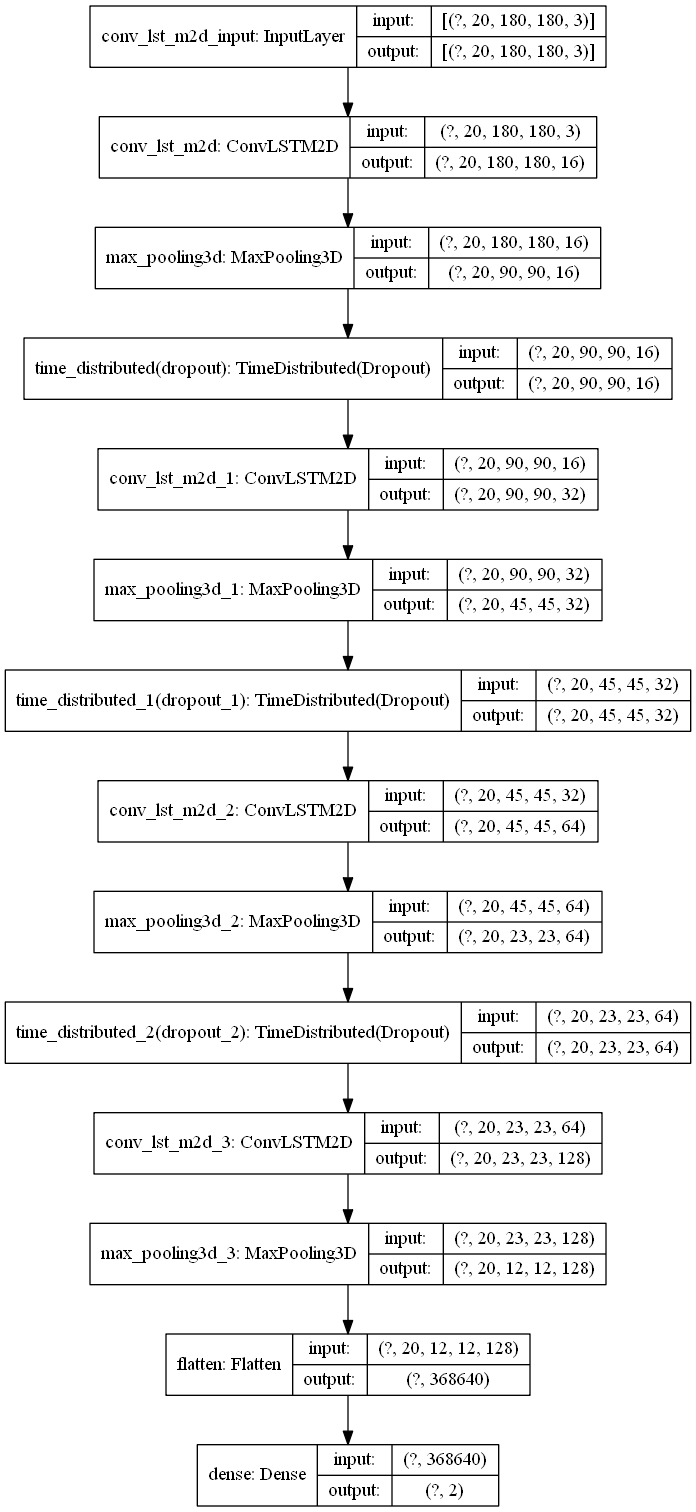

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# Training Visualisation with TensorBoard
path = log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1, update_freq='epoch')

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
hist = model.fit(x=train_ds[0], y=train_ds[1], epochs=100, batch_size=20, validation_data=validation_ds, callbacks=[tensorboard_callback])

Epoch 1/100
1/6 [====>.........................] - ETA: 1s - loss: 0.6998 - accuracy: 0.3000WARNING:tensorflow:From C:\Users\LoveShark\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
6/6 [==============================] - 8s 1s/step - loss: 1.8307 - accuracy: 0.5185 - val_loss: 0.7256 - val_accuracy: 1.0000
Epoch 2/100
6/6 [==============================] - 6s 984ms/step - loss: 0.6626 - accuracy: 0.7222 - val_loss: 0.8627 - val_accuracy: 1.0000
Epoch 3/100
6/6 [==============================] - 6s 951ms/step - loss: 0.4706 - accuracy: 0.7778 - val_loss: 0.9113 - val_accuracy: 1.0000
Epoch 4/100
6/6 [==============================] - 6s 976ms/step - loss: 0.2478 - accuracy: 0.9444 - val_loss: 1.1861 - val_accuracy: 0.6154
Epoch 5/100
6/6 [==============================] - 6s 9

In [ ]:
# Evaluate trained model on test dataset
# model.evaluate(test_batches)